In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt

from lib.sampler import sampler as KTNsampler
from lib.aib_system import aib_system

from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat,find
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

Using tqdm package for pretty progress bars!


# Load Data

  0%|          | 0/48 [00:00<?, ?it/s]

NA, NB, NI: 5 128 767

path: 0 -> 204 -> 401 -> 694 -> 118 -> 424 -> 7 -> 10


path: 10 -> 7 -> 424 -> 118 -> 694 -> 401 -> 204 -> 0



INITIAL SAMPLE DONE : found 273/1004 pairs; 731 remaining
DIRECT =  0 + 0.002451 = 0.002451
GT = 0.002451 +  0 = 0.002451


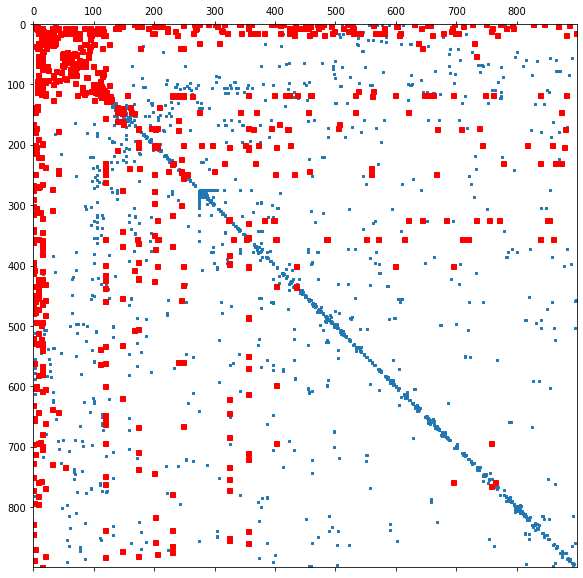

In [2]:
data_dir = "KTN_data/LJ38/4k_proc/"

gt_check = False
generate = False
printout = False

beta = 10.0 # overwritten if generate = False
Emax = None


sys = aib_system(path=data_dir,beta=beta,generate=generate,Emax=Emax)
selA,selB = kio.load_AB(data_dir,np.ones(sys.N,bool))


sys.define_AB_regions(selA,selB)

""" true density """
true_dense = float(sys.K.nnz) / float(sys.K.shape[0]*sys.K.shape[1])

""" Initialize sampler """
sampler = KTNsampler(sys)

depth=4
limit=10
path, path_region = sys.find_path(sys.f[sys.selA].argmin(),sys.f[sys.selB].argmin(),depth=depth,limit=limit,strategy="RATE")
path_r, path_region_r = sys.find_path(sys.f[sys.selB].argmin(),sys.f[sys.selA].argmin(),depth=depth,limit=limit,strategy="RATE")


sampler.initial_sample_path_region(np.arange(sys.N)[path_region+path_region_r],ncs=100)


bab,gterr = sampler.new_true_branching_probability()

plt.figure(figsize=(10,10))

plt.spy(sampler.sys.K,markersize=2.0)
plt.spy(sampler.sys.rK,markersize=5.0,c='r')
plt.show()

In [3]:
bab,gterr = sampler.new_true_branching_probability()

keylist = ['TotalMaxMin','TotalSparseMaxMin','ExpectMaxMin','ExpectMaxMaxMin','SingleMaxMin']


if printout:
    """ open output file """
    name = data_dir.split("/")[-1-int(data_dir[-1]=="/")]
    ff = open('output/pab_converge_%s' % name,'w')
    header = "#iteration\tnrp\tebab\t"
    for key in keylist:
        header += key+"\t"
    header += "Sparsity\tbab\n"
    ff.write(header)

nscycles = 30
ncycles = 100
npairs = 2
ss = 0 # >0 if we do single ended search


for jj in range(nscycles):
    npc=0
    pbar=tqdm(total=ncycles,miniters=0,leave=True)
    ss=False
    ssc=0
    irp = sampler.remaining_pairs()
    pp,gres,npc = sampler.sample(npairs=npairs + 10*int(ss),ss=ss) # sampling process. Returns
    for ii in range(ncycles):

        orp = sampler.remaining_pairs() # DIVINE INFORMATION- number of remaining pairs

        # sampling process returns pp = number of pairs, sens = vector of various net sensitivities and found sparsity, ebab = predicted branching probability (to be compared to bab)
        nnz = sampler.sys.rK.nnz
        pp,res,_npc = sampler.sample(npairs=npairs + 10*int(ss),ss=ss) # sampling process. Returns

        npc += _npc
        if _npc!=(sampler.sys.rK.nnz-nnz)//2:
            print("npc",_npc,sampler.sys.rK.nnz-nnz)
        nrp = sampler.remaining_pairs() # DIVINE INFORMATION- number of remaining pairs
        ss = orp==nrp
        ssc += int(ss)
        probe_compl = float(sampler.probed.sum()) / float(sampler.sys.K.shape[0]*sampler.sys.K.shape[1])

        if printout:
            ff.write("%d %d %10.10g %10.10g " % (ii,nrp,probe_compl,res['ebab']))
            for key in keylist:
                ff.write("%10.10g %10.10g " % (res[key][0],res[key][1]))
            ff.write("%10.10g %10.10g\n" % (res['Sparsity'],bab))

        pbar.update(1)
        for key in ['TotalSparseMaxMin','SingleMaxMin','ExpectMaxMaxMin']:
            gres[key][0] = min(gres[key][0],res[key][0])
            gres[key][1] = max(gres[key][1],res[key][1])
    pbar.close()
    ebab = res['ebab']
    
    print("\n{: <4} {: <5} ".format("%d" % ii,"%1.4g" % (ebab/bab)),end="| ")
    for key in ['TotalSparseMaxMin','SingleMaxMin','ExpectMaxMaxMin']:
        
        tmm = [ (1.0-(1.0-ebab)*np.exp(-gres[key][0]/(1.0-ebab)))/bab,(np.exp(gres[key][1]/ebab)-1.0)*ebab/bab]
        
        print("{: <5} {: <5} {: <5}".format("%1.4g" % tmm[0],"%1.4g" % tmm[1],"%1.4g" % (tmm[0]+tmm[1])),end="| ")
    print("{: <5} {: <5} | {: <5} {: <5} {: <5} | {: <5} {: <5}".format(\
    "%1.4g" % res['Sparsity'],\
    "%1.4g" % probe_compl,\
    "%1.4g" % res['MaxInRegion'][0],"%1.4g" % res['MaxInRegion'][1],"%1.4g" % res['MaxInRegion'][2],\
    "%d" % (irp-nrp),"%d" % (npc)),"\n")

if printout:
    ff.close()



DIRECT =  0 + 0.002451 = 0.002451


  1%|          | 1/100 [00:00<00:10,  9.31it/s]

GT = 0.002451 +  0 = 0.002451


  0%|          | 0/100 [00:00<?, ?it/s]


99   2.258 | 408   -1.42 406.5| 408   -1.311 406.6| 408   -0.4737 407.5| 0.1478 0.003079 | 1.092e+04 1.092e+04 1.628e+07 | 216   216   



  0%|          | 0/100 [00:00<?, ?it/s]


99   2.178 | 408   -2.178 405.8| 408   -2.178 405.8| 408   -2.178 405.8| 0.1073 0.003894 | 2965  2965  1.95e+06 | 95    95    



  0%|          | 0/100 [00:00<?, ?it/s]


99   2.529 | 408   -2.529 405.4| 408   -2.529 405.4| 408   -2.529 405.4| 0.07648 0.00476 | 2.999e+04 2.999e+04 1.65e+05 | 83    83    



  0%|          | 0/100 [00:00<?, ?it/s]


99   2.51  | 408   -2.51 405.5| 408   -2.51 405.5| 408   -2.51 405.5| 0.07041 0.004975 | 2.9e+04 2.9e+04 8.858e+04 | 11    11    



  0%|          | 0/100 [00:00<?, ?it/s]


99   2.51  | 408   -2.51 405.5| 408   -2.51 405.5| 408   -2.51 405.5| 0.06936 0.005015 | 2.9e+04 2.9e+04 7.691e+04 | 0     0     



  0%|          | 0/100 [00:00<?, ?it/s]


99   2.51  | 408   -2.51 405.5| 408   -2.51 405.5| 408   -2.51 405.5| 0.06679 0.005114 | 2.903e+04 2.903e+04 6.121e+04 | 4     4     



  0%|          | 0/100 [00:00<?, ?it/s]


99   2.51  | 408   -2.51 405.5| 408   -2.51 405.5| 408   -2.51 405.5| 0.06568 0.005158 | 2.903e+04 2.903e+04 5.434e+04 | 0     0     



 45%|████▌     | 45/100 [00:14<00:17,  3.06it/s]

KeyboardInterrupt: 

# Plot

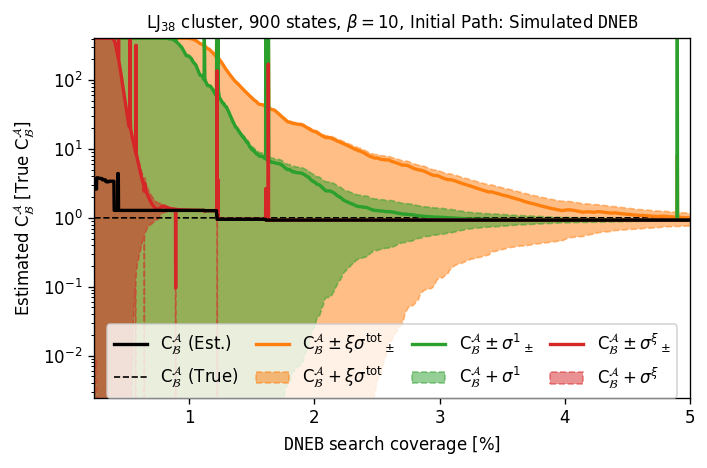

In [19]:
name = data_dir.split("/")[-1-int(data_dir[-1]=="/")]

savefig = True

data = np.loadtxt('output/pab_converge_%s' % name)


filename = 'output/%s/dneb_ip_gs.pdf' % (name)

title = r"LJ$_{38}$ cluster, 900 states, $\beta=$%d, Initial Path: Simulated $\tt{DNEB}$" % (beta)

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=120)

ax.set_title(title,fontsize=10)
ax.set_xlabel(r"$\tt{DNEB}$ search coverage [%]")


ax.set_ylabel(r"Estimated ${\rm C}^\mathcal{A}_\mathcal{B}$ [True ${\rm C}^\mathcal{A}_\mathcal{B}$]")


"""
0-3: iteration nrp probe_compl ebab
4-7: TotalMaxMin +/- TotalSparseMaxMin +/-
8-11: ExpectMaxMin +/- ExpectMaxMaxMin +/-
12-13: SingleMaxMin +/-
14: Sparsity
15: bab
"""

obs = [6,12,8]

"""
Labels
"""

labs = [r"$\xi\sigma^{\rm tot}$",r"${\sigma}^{1}$",r"${\sigma}^{\xi}$"]

labels = [r"${\rm C}^\mathcal{A}_\mathcal{B}$ (Est.)",r"${\rm C}^\mathcal{A}_\mathcal{B}$ (True)"]
for lab in labs:
    labels.append(r"${\rm C}^\mathcal{A}_\mathcal{B}\pm$%s$_\pm$" % lab)
    labels.append(r"${\rm C}^\mathcal{A}_\mathcal{B}+$%s" % lab)


"""
exp bounds
"""
for iii in obs:
    data[:,iii] = (1.0-data[:,3].copy())*(1.-np.exp(-data[:,iii]/(1.0-data[:,3].copy())))
    data[:,iii+1] = data[:,3].copy()*(np.exp(data[:,iii+1]/data[:,3].copy())-1.0)

"""
normalize
"""
bab = data[:,-1][-1].copy()
for iii in obs:
    data[:,iii] /= data[:,-1]
    data[:,iii+1] /= data[:,-1]
data[:,3] /= data[:,-1]
data[:,-1] /= data[:,-1]

xa = data[:,2] * 100.0

t = ax.plot(xa,data[:,-1],'k--',lw=1)[0]

s,sb = [], []
for ci,iii in enumerate(obs):
    sb.append(ax.fill_between(xa,data[:,3]+data[:,iii],data[:,3]+data[:,iii+1],alpha=0.5,color='C'+str(ci+1),lw=1,ls='--'))
for ci,iii in enumerate(obs):
    s.append(ax.plot(xa,data[:,3]+data[:,iii]+data[:,iii+1],'C%s-' % str(ci+1),lw=2)[0])

handles = [ax.plot(xa,data[:,3],'k-',lw=2)[0],t]
for ssi in range(len(sb)):
    handles.append(s[ssi])
    handles.append(sb[ssi])


ax.set_yscale('log')
ax.set_ylim(bab,1.0/bab)
ax.set_xlim(xa.min(),5.0)#xa.max())

ax.legend(handles,labels,loc='lower center',ncol=4, columnspacing=1.0, borderaxespad=0.,fontsize=10) # mode="expand",


plt.tight_layout()

fig.subplots_adjust(hspace=0.4)

if savefig:
    plt.savefig(filename,dpi=400)

plt.show()
